# Workshop 12 - Autoencoders and Pre-Training

Code for workshop 12.  This will use Keras (within tensorflow v2)

---
---
## 1. Initialise the environment

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.9.1
2.9.0


---
---
## 2. Load, inspect and prepare the data

We will use MNIST, which is a set of small images (28x28) that contain 10 
digits - see below for class names and an example image.

(60000, 28, 28)
(10000, 28, 28)
X_all:  (70000, 28, 28)
X_train:  float64
X_valid:  float64
7


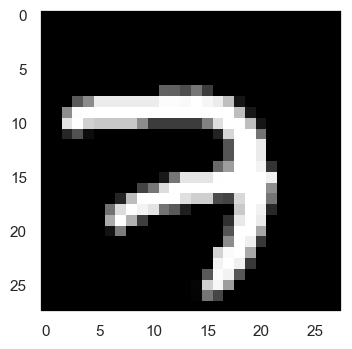

In [2]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

# Scale the data appropriately (it starts with max of 255, but we want
# max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler 
# for this instead. We also split the training set given to us into 
# training and validation subsets 
X_all=np.concatenate((X_train_full,X_test),axis=0)/255
print('X_all: ', X_all.shape)

# The value of 5000 samples as the size of the validation set is an 
# arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])


# Inspect some aspects of the data (in general, you should play around 
# with the data more than this to get a feel for it)
# Check that scaled types are appropriate
print('X_train: ', X_train.dtype)
print('X_valid: ', X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

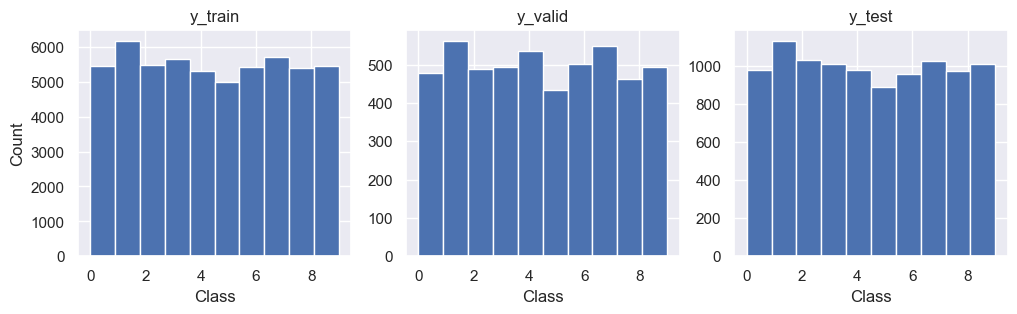

In [3]:
# Let's look at the distribution of labels in the training, validation 
# and test sets
fig, sub = plt.subplots(1, 3)
fig.set_size_inches(12,3)
sub[0].hist(y_train)
sub[0].set_ylabel('Count')
sub[0].set_xlabel('Class')
sub[0].set_title('y_train')
sub[1].hist(y_valid)
sub[1].set_xlabel('Class')
sub[1].set_title('y_valid')
sub[2].hist(y_test)
sub[2].set_xlabel('Class')
sub[2].set_title('y_test')
plt.show()

In [4]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for 
#CNN we need depth too)
X_all = X_all.reshape((-1, 28, 28, 1))
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))
print(X_train.shape)

(55000, 28, 28, 1)


---
---
## 3. Define helper functions that build models in a parameterised way



In [5]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, 
                                  strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    
                                  # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))     # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, 
                                      padding="same", activation=actfn))  
                                      # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2)) # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, 
                                  strides=1, padding="same", activation=actfn))  
                                  # 2nd Conv
    model.add(keras.layers.Flatten())          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  
        # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by 
# replacing the Flatten and Dense lines with model.add(keras.layers.
# Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate 
# a single output per filter which requires the convolution to be "valid" 
# and not "same"

In [6]:
def fit_evaluate(model, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb] + further_callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]),verbose=1)
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history, model)

In [7]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,3))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange',marker=".")
    plt.plot(np.arange(0,n),history.history['loss'],'b',marker=".")
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r',marker=".")  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g',marker=".")
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

---
---
## 4. Define common modelling parameters



In [8]:
# Some key parameters
n_train = 3000
n_valid = 1000
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
#actfn = "relu"
actfn = "selu"
# Optimiser and learning rate
#optimizer = keras.optimizers.SGD
#learningrate = 0.01   # SGD default value
optimizer = keras.optimizers.Nadam
learningrate = 0.001   # Non-SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 50
n_epoch_ae=5

In [9]:
# Early stopping callback - this is executed when fitting and will 
# stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=5, 
                                                  restore_best_weights=True) 

---
---
## 5. Build a simple Convolutional Neural Network

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [10]:
model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten (Flatten)           (None, 784)               0

In [11]:
# Fit and evaluate the model
valacc, testacc, history, model = fit_evaluate(model, n_train, n_valid, n_epochs, batch_size)

Epoch 1/50
94/94 [==============================] - 5s 25ms/step - loss: 0.9182 - accuracy: 0.7427 - val_loss: 0.3860 - val_accuracy: 0.8850
Epoch 2/50
94/94 [==============================] - 3s 27ms/step - loss: 0.2739 - accuracy: 0.9233 - val_loss: 0.2768 - val_accuracy: 0.9260
Epoch 3/50
94/94 [==============================] - 3s 27ms/step - loss: 0.1969 - accuracy: 0.9413 - val_loss: 0.2397 - val_accuracy: 0.9400
Epoch 4/50
94/94 [==============================] - 3s 27ms/step - loss: 0.1486 - accuracy: 0.9567 - val_loss: 0.2171 - val_accuracy: 0.9460
Epoch 5/50
94/94 [==============================] - 3s 28ms/step - loss: 0.1127 - accuracy: 0.9663 - val_loss: 0.2009 - val_accuracy: 0.9390
Epoch 6/50
94/94 [==============================] - 3s 28ms/step - loss: 0.0877 - accuracy: 0.9737 - val_loss: 0.1918 - val_accuracy: 0.9460
Epoch 7/50
94/94 [==============================] - 3s 28ms/step - loss: 0.0657 - accuracy: 0.9800 - val_loss: 0.1788 - val_accuracy: 0.9470
Epoch 8/50
94

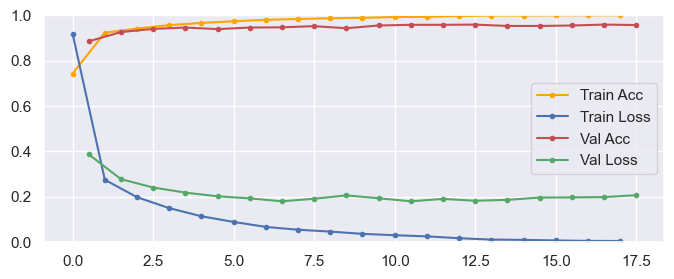

In [12]:
# Inspect the training process
plot_history(history)

In [13]:
# Now run the model on the test set and get results (loss and accuracy 
# both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.14496788382530212, 0.9613999724388123]


1/1 [==============================] - 0s 222ms/step
[7 2 1]
['7' '2' '1']
['7' '2' '1']


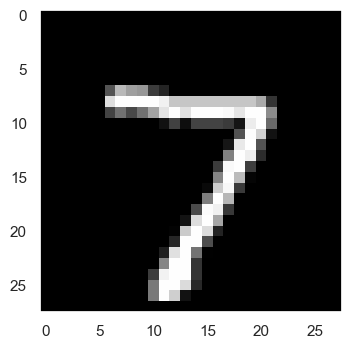

In [14]:
# We can inspect the output class predictions
y_pred = np.argmax(model.predict(X_test[:3]), axis=-1)  
    # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [15]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

1/1 [==============================] - 0s 41ms/step
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---
---
## 6. Build an autoencoder and run on MNIST data



In [16]:
# Build autoencoder using the same hidden sizes as in the plain CNN
hiddensizes_ae=hiddensizes  # use same sizes for exact comparison
#hiddensizes_ae=[16,32,8] # manually change sizes to find optimal bottleneck size
encoder = keras.models.Sequential([ 
    keras.layers.Conv2D(filters=hiddensizes_ae[0], kernel_size=3, padding="same", activation=actfn, 
                        input_shape=[28, 28, 1]), 
    keras.layers.MaxPool2D(pool_size=2, padding="valid"), 
    keras.layers.Conv2D(filters=hiddensizes_ae[1], kernel_size=3, padding="same", activation=actfn), 
    keras.layers.MaxPool2D(pool_size=2, padding="valid"), 
    keras.layers.Conv2D(filters=hiddensizes_ae[2], kernel_size=3, padding="same", activation=actfn), 
    keras.layers.MaxPool2D(pool_size=2, padding="valid") ]) 
encoder.summary()

decoder = keras.models.Sequential([ 
    keras.layers.Conv2DTranspose(filters=hiddensizes_ae[1], kernel_size=3, strides=2, padding="valid", 
                                 activation=actfn, input_shape=[3, 3, hiddensizes_ae[2]]),
    keras.layers.Conv2DTranspose(filters=hiddensizes_ae[0], kernel_size=3, strides=2, padding="same", 
                                 activation=actfn), 
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", 
                                 activation=actfn), 
    keras.layers.Reshape([28, 28, 1]) ]) 
decoder.summary()

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="mse", 
                  optimizer=keras.optimizers.Nadam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 16)        

In [17]:
# Train autoencoder on all data
history = autoencoder.fit(X_all, X_all, epochs=n_epoch_ae, verbose=1)

Epoch 1/5
2188/2188 [==============================] - 66s 29ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321
Epoch 2/5
2188/2188 [==============================] - 60s 28ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953
Epoch 3/5
2188/2188 [==============================] - 60s 27ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832
Epoch 4/5
2188/2188 [==============================] - 64s 29ms/step - loss: 0.0056 - root_mean_squared_error: 0.0748
Epoch 5/5
2188/2188 [==============================] - 59s 27ms/step - loss: 0.0048 - root_mean_squared_error: 0.0694


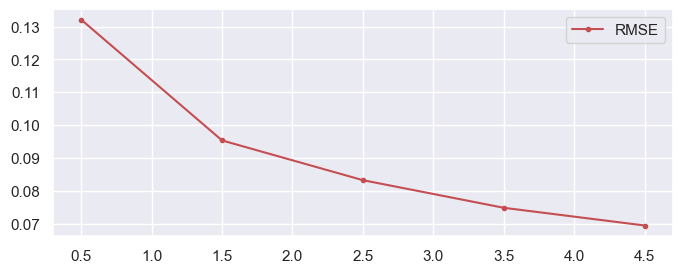

In [18]:
# Inspect the training process, plot the results
plt.figure(figsize=(8,3))
n = len(history.history['loss'])
plt.plot(np.arange(0,n)+0.5,history.history['root_mean_squared_error'],color='r',marker=".")
plt.legend(['RMSE'])
plt.grid(True)
plt.show() 

1/1 [==============================] - 0s 130ms/step


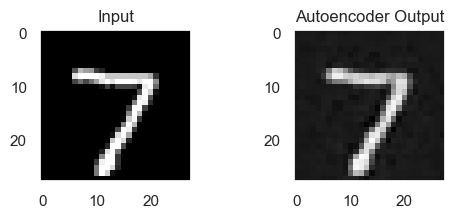

In [19]:
# We can inspect the output predictions (they are images in an autoencoder)
X_pred = autoencoder.predict(X_test[0].reshape((1,28,28,1)))  
    # use the first test case as an example
fig, sub = plt.subplots(1, 2)
fig.set_size_inches(6,2)
sub[0].imshow(X_test[0].reshape((28,28)), cmap="gray")
sub[0].grid(False)
sub[0].set_title('Input')
sub[1].imshow(X_pred[0].reshape((28,28)), cmap="gray")
sub[1].grid(False)
sub[1].set_title('Autoencoder Output')
plt.show()

---
---
## 7. Build a CNN classifier using the pretrained layers of the autoencoder


In [20]:
# Make deep copy of encoder including the coding layer
pretrained_cnn=keras.models.clone_model(encoder)  # does not copy weights
pretrained_cnn.set_weights(encoder.get_weights()) # explicitly copy weights

# Remove the last MaxPool2D layer
pretrained_cnn.pop()

# add the output layers for the classification
pretrained_cnn.add(keras.layers.Flatten())          # unravel into a 1D vector
pretrained_cnn.add(keras.layers.Dense(10, activation = "softmax"))  
    # always have 10 classes
 

In [21]:
# Lock certain layers during training to perserve patterns and to speed up training
pretrained_cnn.layers[0].trainable=False
pretrained_cnn.layers[2].trainable=False
pretrained_cnn.layers[4].trainable=False

pretrained_cnn.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   

pretrained_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 flatten_1 (Flatten)         (None, 784)              

In [22]:
# Fit and evaluate the model
valacc, testacc, history, pretrained_cnn = fit_evaluate(pretrained_cnn, n_train, n_valid,
                                                        n_epochs, batch_size)

Epoch 1/50
94/94 [==============================] - 3s 17ms/step - loss: 1.4983 - accuracy: 0.5393 - val_loss: 1.0270 - val_accuracy: 0.6880
Epoch 2/50
94/94 [==============================] - 1s 14ms/step - loss: 0.8187 - accuracy: 0.7837 - val_loss: 0.7216 - val_accuracy: 0.7940
Epoch 3/50
94/94 [==============================] - 1s 13ms/step - loss: 0.6241 - accuracy: 0.8353 - val_loss: 0.6055 - val_accuracy: 0.8440
Epoch 4/50
94/94 [==============================] - 1s 13ms/step - loss: 0.5266 - accuracy: 0.8610 - val_loss: 0.5493 - val_accuracy: 0.8470
Epoch 5/50
94/94 [==============================] - 1s 13ms/step - loss: 0.4655 - accuracy: 0.8763 - val_loss: 0.5030 - val_accuracy: 0.8630
Epoch 6/50
94/94 [==============================] - 1s 13ms/step - loss: 0.4212 - accuracy: 0.8817 - val_loss: 0.4629 - val_accuracy: 0.8830
Epoch 7/50
94/94 [==============================] - 1s 13ms/step - loss: 0.3865 - accuracy: 0.8943 - val_loss: 0.4367 - val_accuracy: 0.8900
Epoch 8/50
94

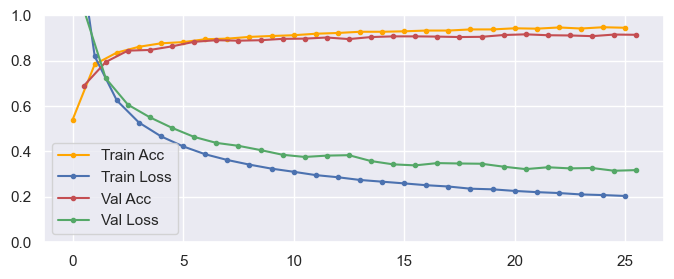

In [23]:
# Inspect the training process
plot_history(history)

In [24]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = pretrained_cnn.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.2925022542476654, 0.9164999723434448]


1/1 [==============================] - 0s 159ms/step
[7 2 1]
['7' '2' '1']
['7' '2' '1']


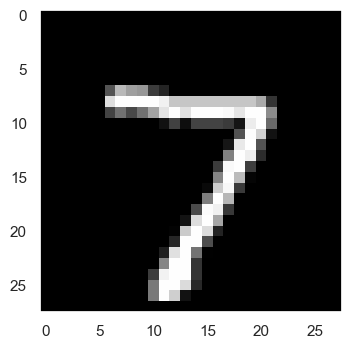

In [25]:
# We can inspect the output class predictions
y_pred = np.argmax(pretrained_cnn.predict(X_test[:3]), axis=-1) # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [26]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = pretrained_cnn.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

1/1 [==============================] - 0s 49ms/step
[[0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.99 0.   0.   0.   0.   0.   0.   0.   0.  ]]


---
---
## 8. Your Tasks

### Pre-training sequence (runs fast): 
After copying the encoder into the new classifier, we make the convolution layers non-trainable and fit only the top layer to the existing layers. Then we have the option of one, several or all layers trainable. We could do it stepwise or in one step. Try the different sequences and find out which one gives the best classification result.

Answer:

### Autoencoder bottleneck (runs slower): 
The autoencoder has a bottleneck at the encoding layer, which forces it to learn general patterns. Experiment with the bottleneck by changing the number of feature maps in the encoding layer. This can be done by setting hiddensizes_ae[2] to the desired value at the start of the cell where the autoencoder is constructed. You can first look at the test output quality and then also create a transfer-learned classifier. Which number of feature maps seems appropriate?

Answer: